<a href="https://colab.research.google.com/github/Stardust-y/B612/blob/master/cnn_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

产生数据

In [45]:
!pip install tensorflow==1.14.1

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==1.14.1


In [33]:
raw_num = 240
col_num = 2000

class Data(object):

    def __init__(self):
        self.data = self.get_data()
        self.label = self.get_label()

    def file_list(self):
        file_list = []
        for file in os.listdir('./data'):
            if not file.endswith('.mat'):
                continue
            file_list.append(file)
        return file_list

    def get_data(self):
        file_list = self.file_list()
        for i in range(len(file_list)):
            if not file_list[i].endswith('.mat'):
                continue
            file = scio.loadmat('./data/{}'.format(file_list[i]))
            for k in file.keys():
                file_matched = re.match('X\d{3}_DE_time', k)
                if file_matched:
                    key = file_matched.group()
            if i == 0:
                data = np.array(file[key][0:480000].reshape(raw_num,col_num))
            else:
                data = np.vstack((data, file[key][0:480000].reshape((raw_num,col_num))))

        return data

    def get_label(self):
        file_list = self.file_list()

        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)

        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))

        return label.flatten()

In [34]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)

(240, 2000)
(480, 2000)
(720, 2000)
(960, 2000)
(1200, 2000)
(1440, 2000)
(1680, 2000)
(1920, 2000)
(2160, 2000)
(2400, 2000)
(2400, 250)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3)

In [50]:
def built_model():
    input_seq = Input(shape=(250,))
    X = Reshape((250, 1))(input_seq)  # 注意这里改成了 channels_last 格式

    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                        padding='valid', activation='tanh')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                        padding='valid', activation='tanh')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, padding='valid')(ec1_layer2)

    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                        padding='valid', activation='tanh')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                        padding='valid', activation='tanh')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, padding='valid')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                        padding='valid', activation='tanh')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                        padding='valid', activation='tanh')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, padding='valid')(ec2_layer5)

    encoder = multiply([ec1_outputs, ec2_outputs])

    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)

    model = Model(input_seq, dc_layer4)

    return model


In [51]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [52]:
import time
begain_time = time.time()

In [53]:
model = built_model()
opt = Adam(learning_rate=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 250, 1)    │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 245, 50)   │        350 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 240, 40)   │     12,040 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 120, 40)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 116, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 115, 30)   │      7,230 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 54, 30)    │     15,030 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 55, 30)    │      5,430 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 27, 30)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 27, 30)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 27, 30)    │          0 │ max_pooling1d_6[… │
│ (Multiply)          │                   │            │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 27, 60)    │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        610 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,620 (361.80 KB)

 Trainable params: 92,620 (361.80 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=400,
                    verbose=2, validation_data=(X_test, y_test),
                    shuffle=True, initial_epoch=0)

Epoch 1/400
17/17 - 15s - 887ms/step - accuracy: 0.1464 - loss: 0.0892 - val_accuracy: 0.0778 - val_loss: 0.0873
Epoch 2/400
17/17 - 8s - 455ms/step - accuracy: 0.1637 - loss: 0.0834 - val_accuracy: 0.1681 - val_loss: 0.0828
Epoch 3/400
17/17 - 7s - 393ms/step - accuracy: 0.2202 - loss: 0.0793 - val_accuracy: 0.2139 - val_loss: 0.0803
Epoch 4/400
17/17 - 9s - 509ms/step - accuracy: 0.2851 - loss: 0.0758 - val_accuracy: 0.2639 - val_loss: 0.0754
Epoch 5/400
17/17 - 5s - 312ms/step - accuracy: 0.3292 - loss: 0.0716 - val_accuracy: 0.3431 - val_loss: 0.0720
Epoch 6/400
17/17 - 9s - 515ms/step - accuracy: 0.3869 - loss: 0.0675 - val_accuracy: 0.3639 - val_loss: 0.0666
Epoch 7/400
17/17 - 5s - 323ms/step - accuracy: 0.4161 - loss: 0.0632 - val_accuracy: 0.4889 - val_loss: 0.0648
Epoch 8/400
17/17 - 9s - 502ms/step - accuracy: 0.4863 - loss: 0.0601 - val_accuracy: 0.5875 - val_loss: 0.0594
Epoch 9/400
17/17 - 5s - 318ms/step - accuracy: 0.5429 - loss: 0.0566 - val_accuracy: 0.5500 - val_loss

In [ ]:
#end_time = time.time()
#time = end_time - begain_time
#print('time:', time)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        86
           1     0.9884    1.0000    0.9942        85
           2     0.9710    1.0000    0.9853        67
           3     1.0000    1.0000    1.0000        56
           4     0.9647    0.9880    0.9762        83
           5     1.0000    0.9878    0.9939        82
           6     1.0000    0.9846    0.9922        65
           7     1.0000    1.0000    1.0000        66
           8     0.9821    0.9322    0.9565        59
           9     1.0000    1.0000    1.0000        71

    accuracy                         0.9903       720
   macro avg     0.9906    0.9893    0.9898       720
weighted avg     0.9904    0.9903    0.9902       720



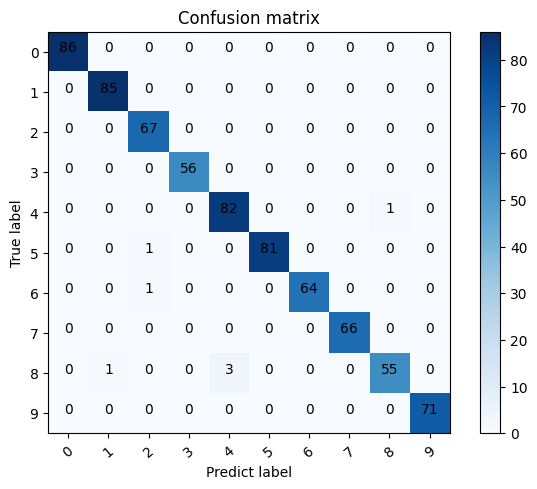

In [55]:
#plt.figure(figsize=(12,9))
from sklearn.metrics import classification_report

y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))
print(classification_report(label_true, label_pre, digits=4))